In [1]:
#!/usr/bin/env python3
import multiprocessing
import os
import subprocess
import sys
import tempfile
import sympy as sp
import numpy as np
import pySecDec as psd

In [2]:
notebookdir = os.getcwd()

In [3]:
signmap = {
  sp.Symbol('x0'): 1,
  sp.Symbol('x1'): 1,
  sp.Symbol('x2'): 1,
}

In [4]:
def needs_cdeform(name, Fpoly):
  poly = sp.sympify(str(Fpoly))
  terms = sp.Add.make_args(poly.expand())
  res = not all((t.subs(signmap) > 0) == True for t in terms)
  print(f'Needs-Contour-Deformation({name}, {poly}) = {res}')
  return res

In [5]:
def call(f):
  return f()

In [6]:
b1_propagators = [
  '(l1)^2-1',
  '(l1 - q1)^2-1',
  '(l1 + q2)^2-1'
]

In [7]:
b1_replacement_rules = [
  ('q1*q1', '0'),
  ('q1*q2', 's12/2'),
  ('q2*q2', '0')
]

In [8]:
def int_0_B1_0_1_1():
  li = psd.loop_integral.LoopIntegralFromPropagators(
    loop_momenta = ['l1'],
    external_momenta = ['q1','q2'],
    propagators = b1_propagators,
    powerlist = [0,1,1],
    replacement_rules = b1_replacement_rules,
    dimensionality = '4-2*eps',
    regulators = ['eps']
  )
  return psd.LoopPackage(
    name = 'B1_0_1_1',
    loop_integral = li,
    real_parameters = ['s12'],
    additional_prefactor = 'I*2^(-4 + 2*eps)*pi^(-2 + eps)',
    decomposition_method = 'iterative',
    form_optimization_level = 4,
    form_work_space = '100M',
    form_threads = 1,
    contour_deformation = needs_cdeform('B1_0_1_1', li.F)
  )

In [9]:
def int_1_B1_1_1_1():
  li = psd.loop_integral.LoopIntegralFromPropagators(
    loop_momenta = ['l1'],
    external_momenta = ['q1','q2'],
    propagators = b1_propagators,
    powerlist = [1,1,1],
    replacement_rules = b1_replacement_rules,
    dimensionality = '4-2*eps',
    regulators = ['eps']
  )
  return psd.LoopPackage(
    name = 'B1_1_1_1',
    loop_integral = li,
    real_parameters = ['s12'],
    additional_prefactor = 'I*2^(-4 + 2*eps)*pi^(-2 + eps)',
    decomposition_method = 'geometric_ku',
    form_optimization_level = 4,
    form_work_space = '100M',
    form_threads = 1,
    contour_deformation = needs_cdeform('B1_1_1_1', li.F)
  )

In [10]:
if __name__ == '__main__':
  # Always start in the directory this file resides in
  thisdir = os.path.dirname(sys.argv[0])
  if thisdir: os.chdir(os.path.dirname(sys.argv[0]))

In [11]:
  make_integrals = [
    int_0_B1_0_1_1,
    int_1_B1_1_1_1,
  ]

In [12]:
  coefficients = {
    "gH*gs^2*ImagI*Na*Tf*flvsumt[1]": {
      0: "(-16*eps*mt1)/(2 - 2*eps)",
      1: "(4*mt1*(-8 - 2*s12 + (4 - 2*eps)*s12))/(2 - 2*eps)",
    },
  }
  try:
    nthreads = int(os.environ['THREADS'])
  except KeyError:
    try:
      nthreads = len(os.sched_getaffinity(0))
    except AttributeError:
      nthreads = os.cpu_count()
  if nthreads > 1:
    with multiprocessing.Pool(nthreads) as pool:
      integrals = pool.map(call, make_integrals)
  else:
    integrals = [f() for f in make_integrals]
  subprocess.check_call(['rm', '-rf', 'disteval'])
  cwd = os.getcwd()
  with tempfile.TemporaryDirectory(prefix='psd') as tmp:
    os.chdir(tmp)
    psd.sum_package('sum',
      integrals,
      coefficients = coefficients,
      regulators = ['eps'],
      requested_orders = [0],
      real_parameters = ['s12'],
      processes = nthreads,
    )
    subprocess.check_call(['make', '-C', 'sum', '-j', str(nthreads), 'disteval.done'])
    subprocess.check_call(['cp', '-a', 'sum/disteval', cwd])
    subprocess.check_call(['rm', '-rf', 'sum'])

Needs-Contour-Deformation(B1_1_1_1, x0**2 + 2*x0*x1 + 2*x0*x2 + x1**2 + x1*x2*(2 - s12) + x2**2) = True
Needs-Contour-Deformation(B1_0_1_1, x1**2 + x1*x2*(2 - s12) + x2**2) = True
running "sum_package" for sum
running "make_package" for "B1_1_1_1"
running "make_package" for "B1_0_1_1"
number of primary sectors before symmetry finding: number of primary sectors before symmetry finding:2 3

number of primary sectors after symmetry finding (iterative): 1
number of primary sectors after symmetry finding (light Pak): number of primary sectors after symmetry finding (iterative):1
 
number of primary sectors after symmetry finding (full Pak): 12
computing Jacobian determinant for primary sector 0
total number sectors before symmetry finding: 1
number of primary sectors after symmetry finding (light Pak):total number sectors after symmetry finding (iterative):  21

number of primary sectors after symmetry finding (full Pak): 2total number sectors after symmetry finding (light Pak):
 computing 

In [13]:
from pySecDec.integral_interface import DistevalLibrary

os.chdir(notebookdir)
ggH_1L = DistevalLibrary('disteval/sum.json', verbose=False)

In [14]:
res1 = ggH_1L(parameters={"s12": 2.11426927144226, "mt1": 1.0}, epsrel=1e-4, epsabs=1e-10, format="json")
res2 = ggH_1L(parameters={"s12": 4.523321402575598, "mt1": 1.0}, epsrel=1e-4, epsabs=1e-10, format="json")

In [35]:
result1, result2 = res1['sums']['gH*gs^2*ImagI*Na*Tf*flvsumt[1]'], res2['sums']['gH*gs^2*ImagI*Na*Tf*flvsumt[1]']
print('eps^0 :', -result1[( 0,)][0]/2, '+/- (', -result1[( 0,)][1]/2, ')')
print('eps^0 :', -result2[( 0,)][0]/2, '+/- (', -result2[( 0,)][1]/2, ')')

eps^0 : (-1.0251850223827722e-15+0.010361453077406546j) +/- ( (-1.0317818879395938e-15-7.708686780390905e-16j) )
eps^0 : (-0.003261442304233053+0.03219341118936804j) +/- ( (-6.415820503914573e-16-7.199281284855906e-16j) )


In [36]:
res_theo = 1j*np.array([1.63621509+0.j, 5.08377972+0.51502633j])/(16*np.pi**2)
res_alib = -np.array([result1[( 0,)][0], result2[( 0,)][0]])/2

In [37]:
print(res_alib/res_theo)

[1.+9.89422055e-14j 1.-1.03318627e-09j]


In [46]:
import matplotlib.pyplot as plt

s12, m12 = np.linspace(2, 6, 100), []
for s_value in s12:
    raw_data = ggH_1L(parameters={"s12": s_value, "mt1": 1.0}, epsrel=1e-4, epsabs=1e-10, format="json")
    m12.append(raw_data['sums']['gH*gs^2*ImagI*Na*Tf*flvsumt[1]'][( 0,)][0])
m12 = -0.5*np.array(m12)

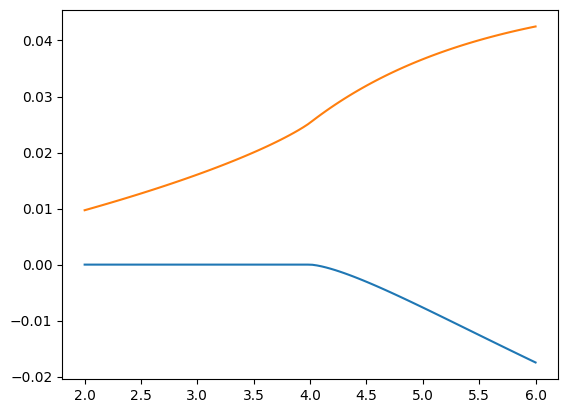

In [47]:
plt.plot(s12, m12.real)
plt.plot(s12, m12.imag)
plt.show()

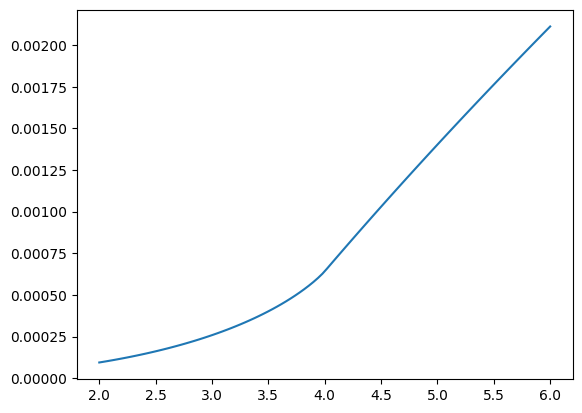

In [54]:
plt.plot(s12, np.abs(m12)**2)
plt.show()